### Statistical and Grid network package

In [1]:
import os
import numpy as np
import networkx as nx
import pandas as pd
import torch
import copy

#Pandapower Package
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import pandapower.diagnostic as diagnostic

from pandapower.powerflow import LoadflowNotConverged
from pandapower.diagnostic import diagnostic
from pandapower.control import ConstControl
from pandapower.timeseries import DFData, OutputWriter, run_timeseries
from pandapower.pypower.makeYbus import makeYbus

import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.linalg
import scipy.sparse as sp
from scipy.stats import gaussian_kde
from itertools import product
from tqdm import tqdm
import seaborn as sns

### Causal Discovery and Causal Inference Package

In [3]:
import causallearn
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import fisherz
from causallearn.search.ScoreBased.GES import ges
from causallearn.score.LocalScoreFunction import local_score_BIC
from causallearn.search.FCMBased.PNL.PNL import PNL
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from dowhy import gcm # Graphical Causal Models 
from lingam import DirectLiNGAM
from scipy.special import psi

import warnings
from sklearn.exceptions import ConvergenceWarning  

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
### load the Dataset

In [4]:
# === Load the Dataset ===
data = pd.read_excel('Causal_reliability_Contingnecy_case3_10000.xlsx')

# === Drop rows with missing values ===
data = data.dropna()

# === Drop non-numeric columns (e.g., Scenario labels) ===
non_numeric_cols = ['Scenario', 'Contingency']
data = data.drop(columns=[col for col in non_numeric_cols if col in data.columns])

# === Drop constant columns (zero or near-zero variance) ===
data = data.loc[:, data.apply(pd.Series.nunique) > 2]

# === Drop voltage angle features (e.g., those ending with '_va_degree') ===
angle_cols = [col for col in data.columns if 'va_degree' in col.lower()]
data = data.drop(columns=angle_cols)

# === Normalize the numerical data ===
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# === SView cleaned, scaled dataset ===
print(data_scaled.head())

   Sgen1_Mean_Solar Output  Sgen2_Mean_Solar Output  Sgen3_Mean_Solar Output  \
0                -0.313987                 1.302932                 1.018757   
1                 0.084634                 0.221877                -1.437740   
2                -0.742715                -1.035454                -0.792086   
3                 0.708357                 0.505936                -1.549172   
4                -0.076902                 0.955014                 0.007639   

   Sgen4_Mean_Solar Output  Sgen5_Mean_Solar Output  Sgen6_Mean_Solar Output  \
0                 0.387551                -1.073798                -1.221429   
1                -0.281110                 0.744930                 1.101396   
2                 0.329102                -1.504700                 1.246061   
3                -1.128131                -0.987697                 1.052326   
4                 1.085061                 1.251976                -0.547249   

   Sgen7_Mean_Solar Output  Sgen8_Mean

### Test 1: SGEN-ACTIVE POWER WITH LOLP


[Summary of Treatments]
       Sgen1_Mean_Solar Output  Sgen2_Mean_Solar Output  \
count              9998.000000              9998.000000   
mean                  5.558941                 5.673035   
std                   2.883357                 2.784475   
min                   0.000000                 0.379059   
25%                   2.913265                 3.093049   
50%                   5.891394                 6.012862   
75%                   8.317352                 8.306766   
max                   9.706308                 9.683572   

       Sgen3_Mean_Solar Output  Sgen4_Mean_Solar Output  \
count              9998.000000              9998.000000   
mean                  5.633303                 5.629613   
std                   2.780213                 2.791093   
min                   0.378679                 0.379953   
25%                   3.114549                 3.067488   
50%                   5.929889                 5.904836   
75%                   8.296811

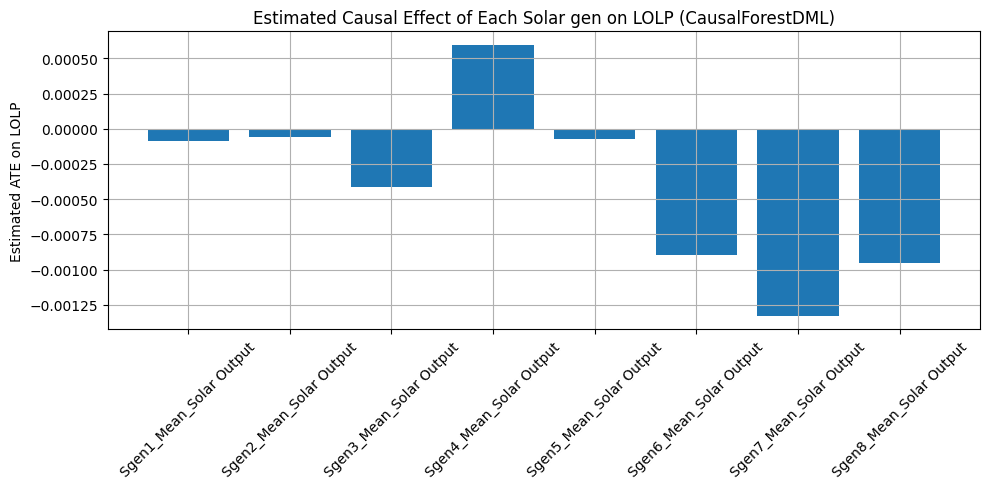

In [5]:
# Define treatment and outcome
treatments = [col for col in data.columns if "Sgen" in col and "Output" in col]
outcome = "LOLP"

# Summary diagnostics
print("\n[Summary of Treatments]")
print(data[treatments].describe())

print("\n[Summary of LOLP before scaling]")
print(data[outcome].describe())

# Filter numeric covariates only
numeric_data = data.select_dtypes(include=[np.number])
all_numeric_cols = set(numeric_data.columns)
covariates = list(all_numeric_cols - set(treatments) - {outcome})

X = data[covariates]
Y = data[outcome]

# Scale covariates (optional)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize causal effect storage
effect_results = {}

# Iterate over each treatment variable
for treat in treatments:
    print(f"\n[Running CausalForestDML for treatment: {treat}]")

    T = data[treat].values

    model = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_t=RandomForestRegressor(n_estimators=100),
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=10,
        verbose=0,
        discrete_treatment=False,
        random_state=42
    )

    model.fit(Y, T, X=X_scaled)

    # Estimate treatment effect
    treatment_effect = model.effect(X_scaled)
    ate = np.mean(treatment_effect)
    effect_results[treat] = ate
    print(f"Estimated ATE for {treat} on {outcome}: {ate:.5f}")

# Visualize results
plt.figure(figsize=(10, 5))
plt.bar(effect_results.keys(), effect_results.values())
plt.ylabel("Estimated ATE on LOLP")
plt.title("Estimated Causal Effect of Each Solar gen on LOLP (CausalForestDML)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


[Estimating: Sgen2_Mean_Solar Output → Bus4_Mean_vm_pu]
  Estimated ATE: 0.0000027006

[Estimating: Sgen2_Mean_Solar Output → Bus6_Mean_vm_pu]
  Estimated ATE: 0.0000007750

[Estimating: Sgen1_Mean_Solar Output → Bus3_Mean_vm_pu]
  Estimated ATE: 0.0000007818

[Estimating: Sgen1_Mean_Solar Output → Bus2_Mean_vm_pu]
  Estimated ATE: 0.0000000212

[Estimating: Sgen3_Mean_Solar Output → Bus6_Mean_vm_pu]
  Estimated ATE: 0.0000027410

[Estimating: Sgen4_Mean_Solar Output → Bus8_Mean_vm_pu]
  Estimated ATE: -0.0000034714

[Estimating: Sgen4_Mean_Solar Output → Bus10_Mean_vm_pu]
  Estimated ATE: 0.0000041063

[Estimating: Sgen7_Mean_Solar Output → Bus19_Mean_vm_pu]
  Estimated ATE: -0.0000000819

[Estimating: Sgen8_Mean_Solar Output → Shortest Gen-to-Gen Impedance]
  Estimated ATE: -0.0000186918

[Estimating: Sgen8_Mean_Solar Output → Bus16_Mean_vm_pu]
  Estimated ATE: -0.0000004779

[Estimating: Longest Gen-to-Gen Impedance → Shorest Gen-to-Gen Impedance]
  Missing column: Longest Gen-to-G

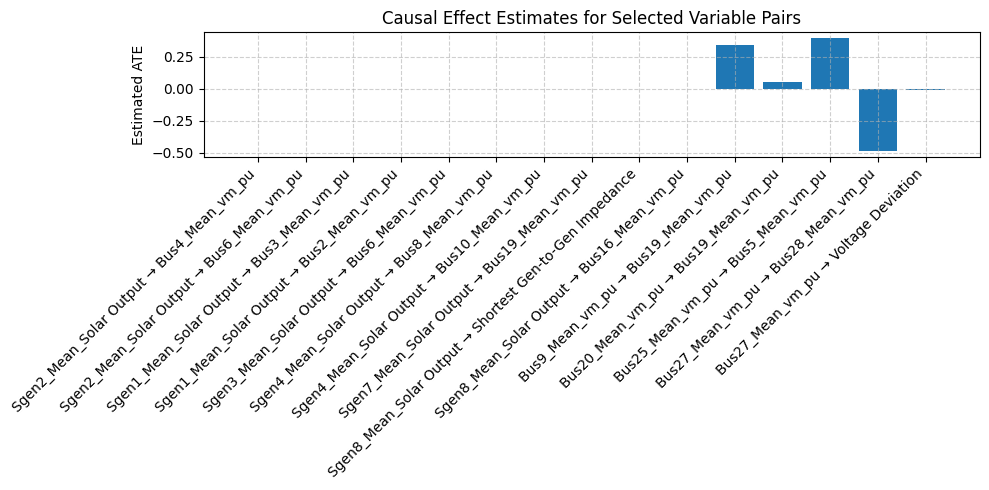

In [10]:
# === Define specific (treatment, outcome) pairs ===
query_pairs = [
    ("Sgen2_Mean_Solar Output", "Bus4_Mean_vm_pu"),
    ("Sgen2_Mean_Solar Output", "Bus6_Mean_vm_pu"),
    ("Sgen1_Mean_Solar Output", "Bus3_Mean_vm_pu"),
    ("Sgen1_Mean_Solar Output", "Bus2_Mean_vm_pu"),
    ("Sgen3_Mean_Solar Output", "Bus6_Mean_vm_pu"),
    ("Sgen4_Mean_Solar Output", "Bus8_Mean_vm_pu"),
    ("Sgen4_Mean_Solar Output", "Bus10_Mean_vm_pu"),
    ("Sgen7_Mean_Solar Output", "Bus19_Mean_vm_pu"),
    ("Sgen8_Mean_Solar Output", "Shortest Gen-to-Gen Impedance"),
    ("Sgen8_Mean_Solar Output", "Bus16_Mean_vm_pu"),
    ("Longest Gen-to-Gen Impedance", "Shorest Gen-to-Gen Impedance"),
     ("Bus9_Mean_vm_pu", "Bus19_Mean_vm_pu"),
    ("Bus20_Mean_vm_pu", "Bus19_Mean_vm_pu"),
    ("Bus25_Mean_vm_pu", "Bus5_Mean_vm_pu"),
     ("Bus27_Mean_vm_pu", "Bus28_Mean_vm_pu"),
    ("Bus27_Mean_vm_pu", "Voltage Deviation")
]

# === Filter numeric variables and scale covariates ===
numeric_data = data.select_dtypes(include=[np.number])
all_numeric_cols = list(numeric_data.columns)

# Initialize results
pair_results = {}

for treat, outcome in query_pairs:
    print(f"\n[Estimating: {treat} → {outcome}]")

    # Check columns exist
    if treat not in data.columns or outcome not in data.columns:
        print(f"  Missing column: {treat} or {outcome}")
        continue

    Y = data[outcome].values
    T = data[treat].values

    # Use all other numeric variables as covariates (excluding current T and Y)
    covariates = list(set(all_numeric_cols) - {treat, outcome})
    X = data[covariates]
    
    # Scale covariates
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit CausalForestDML
    model = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_t=RandomForestRegressor(n_estimators=100),
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=10,
        verbose=0,
        discrete_treatment=False,
        random_state=42
    )

    model.fit(Y, T, X=X_scaled)
    treatment_effect = model.effect(X_scaled)
    ate = np.mean(treatment_effect)

    pair_results[f"{treat} → {outcome}"] = ate
    print(f"  Estimated ATE: {ate:.10f}")

# === Visualization ===
plt.figure(figsize=(10, 5))
plt.bar(pair_results.keys(), pair_results.values())
plt.ylabel("Estimated ATE")
plt.title("Causal Effect Estimates for Selected Variable Pairs")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


[Estimating: Longest Gen-to-Gen Impedance → Shortest Gen-to-Gen Impedance]
  Estimated ATE: 1.5748367444

[Estimating: Longest Gen-to-Load Impedance → Shortest Gen-to-Gen Impedance]
  Estimated ATE: 1.6924192332

[Estimating: Longest Load-to-Load Impedance → Shortest Gen-to-Gen Impedance]
  Estimated ATE: 1.5857032977

[Estimating: Bus18_Mean_vm_pu → Bus17_Mean_vm_pu]
  Estimated ATE: 0.7685482027

[Estimating: Bus7_Mean_vm_pu → Bus25_Mean_vm_pu]
  Estimated ATE: 0.0428154525


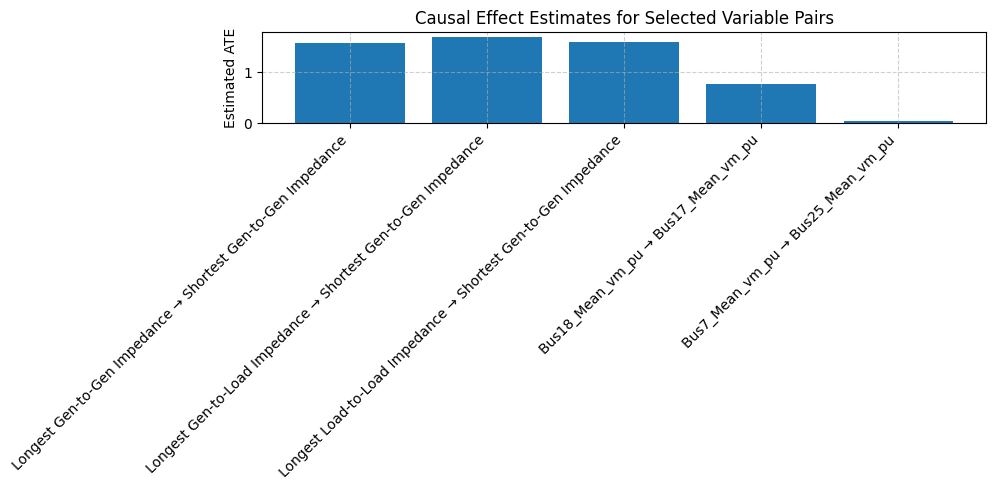

In [13]:
# === Define specific (treatment, outcome) pairs ===
query_pairs = [
    ("Longest Gen-to-Gen Impedance", "Shortest Gen-to-Gen Impedance"),
    ("Longest Gen-to-Load Impedance", "Shortest Gen-to-Gen Impedance"),
    ("Longest Load-to-Load Impedance", "Shortest Gen-to-Gen Impedance"),
    ("Bus18_Mean_vm_pu", "Bus17_Mean_vm_pu"),
    ("Bus7_Mean_vm_pu", "Bus25_Mean_vm_pu")
]

# === Filter numeric variables and scale covariates ===
numeric_data = data.select_dtypes(include=[np.number])
all_numeric_cols = list(numeric_data.columns)

# Initialize results
pair_results = {}

for treat, outcome in query_pairs:
    print(f"\n[Estimating: {treat} → {outcome}]")

    # Check columns exist
    if treat not in data.columns or outcome not in data.columns:
        print(f"  Missing column: {treat} or {outcome}")
        continue

    Y = data[outcome].values
    T = data[treat].values

    # Use all other numeric variables as covariates (excluding current T and Y)
    covariates = list(set(all_numeric_cols) - {treat, outcome})
    X = data[covariates]
    
    # Scale covariates
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit CausalForestDML
    model = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_t=RandomForestRegressor(n_estimators=100),
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=10,
        verbose=0,
        discrete_treatment=False,
        random_state=42
    )

    model.fit(Y, T, X=X_scaled)
    treatment_effect = model.effect(X_scaled)
    ate = np.mean(treatment_effect)

    pair_results[f"{treat} → {outcome}"] = ate
    print(f"  Estimated ATE: {ate:.10f}")

# === Visualization ===
plt.figure(figsize=(10, 5))
plt.bar(pair_results.keys(), pair_results.values())
plt.ylabel("Estimated ATE")
plt.title("Causal Effect Estimates for Selected Variable Pairs")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# === Define specific (treatment, outcome) pairs ===
query_pairs = [

    ("Bus28_Mean_vm_pu", "Shortest Gen-to-Gen Impedance"),
    ("Shortest Gen-to-Gen Impedance","Bus25_Mean_vm_pu")

]

# === Filter numeric variables and scale covariates ===
numeric_data = data.select_dtypes(include=[np.number])
all_numeric_cols = list(numeric_data.columns)

# Initialize results
pair_results = {}

for treat, outcome in query_pairs:
    print(f"\n[Estimating: {treat} → {outcome}]")

    # Check columns exist
    if treat not in data.columns or outcome not in data.columns:
        print(f"  Missing column: {treat} or {outcome}")
        continue

    Y = data[outcome].values
    T = data[treat].values

    # Use all other numeric variables as covariates (excluding current T and Y)
    covariates = list(set(all_numeric_cols) - {treat, outcome})
    X = data[covariates]
    
    # Scale covariates
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit CausalForestDML
    model = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
        model_t=RandomForestRegressor(n_estimators=100),
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=10,
        verbose=0,
        discrete_treatment=False,
        random_state=42
    )

    model.fit(Y, T, X=X_scaled)
    treatment_effect = model.effect(X_scaled)
    ate = np.mean(treatment_effect)

    pair_results[f"{treat} → {outcome}"] = ate
    print(f"  Estimated ATE: {ate:.10f}")

# === Visualization ===
plt.figure(figsize=(10, 5))
plt.bar(pair_results.keys(), pair_results.values())
plt.ylabel("Estimated ATE")
plt.title("Causal Effect Estimates for Selected Variable Pairs")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()